In [1]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 18.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 18.8 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [2]:
from transformers import BertTokenizer, BertForSequenceClassification

# Load pre-trained mBERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-multilingual-uncased', num_labels=2)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/872k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.72M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/672M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [3]:
import pandas as pd
train_data=pd.read_csv("/content/subtaskB_train_edited.csv")
eval_data=pd.read_csv("/content/taskB_combined_eval_edited.csv")
train_texts=train_data['tweet'].tolist()
eval_texts=eval_data['tweet'].tolist()

In [7]:
train_labels=train_data['label']
eval_labels=eval_data['truth_label']

In [4]:
# Preprocess the data
train_encodings = tokenizer(train_texts, truncation=True, padding=True)
eval_encodings = tokenizer(eval_texts, truncation=True, padding=True)

In [8]:
import torch
class HateSpeechDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

# Create dataset instances
train_dataset = HateSpeechDataset(train_encodings, train_labels)
eval_dataset = HateSpeechDataset(eval_encodings, eval_labels)

In [12]:
# Fine-tune the model
from torch.utils.data import DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True) # Creating the train_dataloader variable
eval_dataloader = DataLoader(eval_dataset, batch_size=16, shuffle=False)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

for epoch in range(5):
    model.train()
    total_loss = 0
    for batch in train_dataloader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()

        # Get the model's output
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)

        # The loss is already calculated by the model when labels are provided
        loss = outputs.loss
        #loss = criterion(outputs.logits, labels) # This line is no longer needed and was causing the error.

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    print(f'Epoch {epoch+1}, Loss: {total_loss / len(train_dataloader)}')

Epoch 1, Loss: 0.3091195175128786
Epoch 2, Loss: 0.2615806265434754
Epoch 3, Loss: 0.21754754149450575
Epoch 4, Loss: 0.17348007853938768
Epoch 5, Loss: 0.13149185594391674


In [15]:
# prompt: save the above model

import torch

# Save the model
model.save_pretrained("hate speech_model_bert")
# Save the tokenizer (optional, but recommended)
tokenizer.save_pretrained('hate_speech_tokenizer')

('hate_speech_tokenizer/tokenizer_config.json',
 'hate_speech_tokenizer/special_tokens_map.json',
 'hate_speech_tokenizer/vocab.txt',
 'hate_speech_tokenizer/added_tokens.json')

In [16]:
# Evaluate the model
model.eval()
eval_loss = 0
correct = 0
with torch.no_grad():
    for batch in eval_dataloader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        # Pass the logits (outputs.logits) to the criterion function
        loss = criterion(outputs.logits, labels)
        eval_loss += loss.item()
        _, predicted = torch.max(outputs.logits, dim=1) # Changed outputs.scores to outputs.logits for consistency
        correct += (predicted == labels).sum().item()

accuracy = correct / len(eval_labels)
print(f'Eval Loss: {eval_loss / len(eval_dataloader)}')
print(f'Eval Accuracy: {accuracy:.4f}')

Eval Loss: 0.35796959683093954
Eval Accuracy: 0.8772


In [17]:
test_data=pd.read_csv("/content/taskB_combined_test_edit.csv")
test_texts=test_data['tweet'].tolist()

In [19]:
# prompt: use the model  to predict on test_texts and use the predictaed labels and the truth_labels of test_data to get the classification report ,confusion matrix

from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Load the saved model and tokenizer
model = BertForSequenceClassification.from_pretrained("hate speech_model_bert")
tokenizer = BertTokenizer.from_pretrained('hate_speech_tokenizer')

# Ensure the model is on the correct device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device) # Move the model to the device

# Preprocess the test data
test_encodings = tokenizer(test_texts, truncation=True, padding=True)
test_dataset = HateSpeechDataset(test_encodings, test_data['truth_label'].tolist())  # Use 'truth_label'
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Make predictions on the test set
model.eval()
predicted_labels = []
truth_labels = []

with torch.no_grad():
    for batch in test_dataloader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask)
        _, predicted = torch.max(outputs.logits, dim=1)
        predicted_labels.extend(predicted.cpu().numpy())
        truth_labels.extend(labels.cpu().numpy())

# Generate classification report and confusion matrix
print(classification_report(truth_labels, predicted_labels))
print(confusion_matrix(truth_labels, predicted_labels))

              precision    recall  f1-score   support

           0       0.92      0.95      0.93      3553
           1       0.49      0.39      0.43       470

    accuracy                           0.88      4023
   macro avg       0.70      0.67      0.68      4023
weighted avg       0.87      0.88      0.87      4023

[[3358  195]
 [ 286  184]]


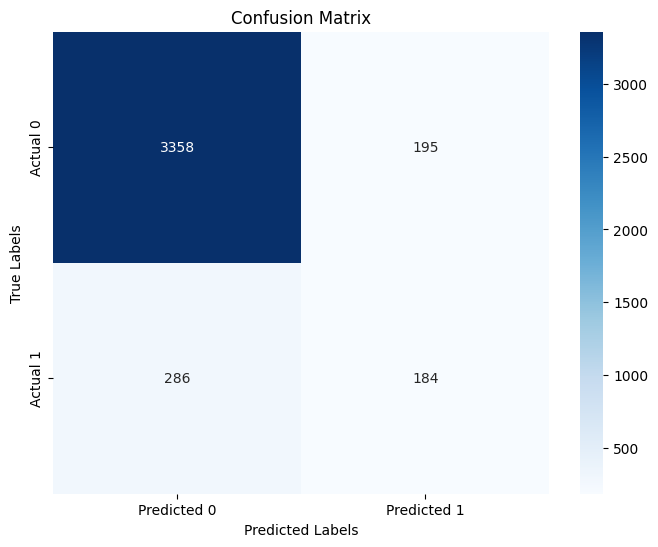

In [20]:
# prompt: plot the confusion matrix

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Assuming truth_labels and predicted_labels are already defined from the previous code

cm = confusion_matrix(truth_labels, predicted_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

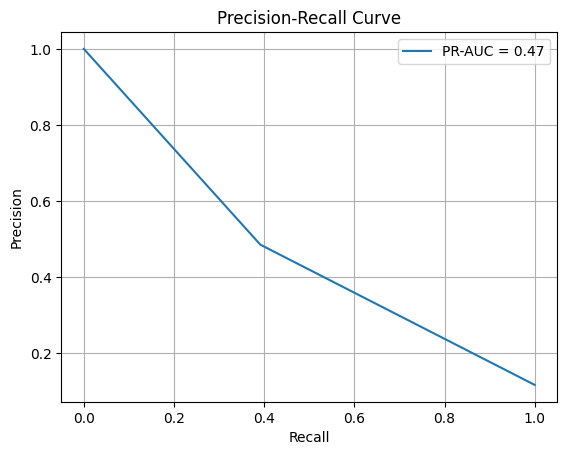

In [21]:
# prompt: plot the PR-AUC

from sklearn.metrics import precision_recall_curve, auc
import matplotlib.pyplot as plt

# Assuming truth_labels and predicted_labels are already defined from the previous code
# Calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(truth_labels, predicted_labels)

# Calculate PR-AUC
pr_auc = auc(recall, precision)

# Plot the PR-AUC curve
plt.plot(recall, precision, label=f'PR-AUC = {pr_auc:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.show()